# Visualising the tweet data

For this task the sentiment analysis performed using 'Textblob' 
is used, because it provides a continuous value 'polarity' as 
opposed to a categorical 'positive'/'negative' value.

Polarity ranges from -1.0 (negative) to +1.0 (positive)

## Prepare data

Get data from sqlite database and insert into pandas DataFrame.

In [1]:
from brexittweets.custom_funcs.sqlite_functions import create_dataframe_timeseries

df = create_dataframe_timeseries(slot = 10)
df.head()

,id,polarity,sentiment,year,month,day,hour,minute,datetime_slot
1,1,0.00,neutral,2020,2,23,17,20,2020-02-23 17:20:00
2,2,0.40,positive,2020,2,23,17,20,2020-02-23 17:20:00
3,3,0.00,neutral,2020,2,23,17,20,2020-02-23 17:20:00
4,4,0.00,neutral,2020,2,23,17,20,2020-02-23 17:20:00
5,5,0.25,positive,2020,2,23,17,20,2020-02-23 17:20:00


There are large gaps in the data when the streaming script was not running.
For this exercise the data will be filtered to the first block of tweets that 
were streamed with <60 minutes between them.

In [2]:
df_test = df.copy()
import pandas as pd
df_test['diff'] = (df_test['datetime_slot']-df_test['datetime_slot'].shift()).fillna(pd.Timedelta(seconds=0))
gaps = df_test[df_test['diff']>pd.Timedelta(minutes = 30)].copy()
gaps['count_vals'] = gaps['id'] - gaps['id'].shift().fillna(0)
gaps

,id,polarity,sentiment,year,month,day,hour,minute,datetime_slot,diff,count_vals
8127,8127,0.0000,neutral,2020,2,24,8,10,2020-02-24 08:10:00,05:00:00,8127.0
9291,9291,-0.0725,neutral,2020,2,24,13,10,2020-02-24 13:10:00,04:10:00,1164.0
10402,10402,0.2250,positive,2020,2,24,15,30,2020-02-24 15:30:00,01:20:00,1111.0


This tells us that 8127 tweets were collected from the beginning 
of the stream up until datetime slot 2020-02-24 08:10:00. We will filter
the data to only include these tweets.

In [3]:
df_filtered = df[df['id'] < 8127]
df_filtered.shape

(8126, 9)

Aggregate the time series data into time slots to explore
 sentiment over time. Default duration of time slot is five minutes.

This table shows the count of negative, neutral (polarity between -0.1 
and +0.1), and positive tweets in each time slot, as well as the 
percentage of tweets that are positive.

In [4]:
from brexittweets.custom_funcs.utils import aggregate_sentiment_data
df_grouped = aggregate_sentiment_data(df_filtered)
df_grouped.head()

sentiment,datetime_slot,negative,neutral,positive,percentage_positive,day
0,2020-02-23 17:20:00,19.0,93.0,43.0,0.277419,23
1,2020-02-23 17:30:00,50.0,129.0,55.0,0.235043,23
2,2020-02-23 17:40:00,45.0,116.0,64.0,0.284444,23
3,2020-02-23 17:50:00,34.0,116.0,51.0,0.253731,23
4,2020-02-23 18:00:00,24.0,60.0,52.0,0.382353,23


## Visualise data

First, a plot is generated to display sentiment over time. For this chart, polarity was divided
into 'positive', 'negative' and 'neutral' (-0.1 - 0.1) categories and the number
of tweets in each category counted for each time slot.

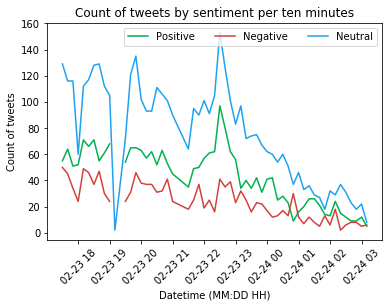

In [5]:
import matplotlib.pyplot as plt
from brexittweets.config import plots_output_path as pop
from brexittweets.config import twitter_blue

# identify tweets that take place in a single period of streaming
df_grouped['day'] = df['datetime_slot'].apply(lambda x: x.date().day)
day_23 = df_grouped[df_grouped.day == 23]

# Extract these tweets from the dataframe

x = day_23.loc[:, 'datetime_slot']
y = day_23.loc[:, 'percentage_positive']

# Extract positive, negative and neutral tweets as series

pos = day_23.loc[:, 'positive']
neg = day_23.loc[:, 'negative']
neu = day_23.loc[:, 'neutral']

# In first plot track count of different sentiments

x_label = 'Datetime (MM:DD HH)'

plt.plot(x, pos, label='Positive', color='#00B050')
plt.plot(x, neg, label='Negative', color='#D53F3B')
plt.plot(x, neu, label='Neutral', color = twitter_blue)

# Add labels and legend

plt.xlabel(x_label)
plt.ylabel('Count of tweets')
plt.title('Count of tweets by sentiment per ten minutes')
plt.legend(loc='upper right', ncol=3)
plt.xticks(rotation=45)

# Display
plt.show()

On inspection of the plot, a gap in the data is revealed somewhere between
7pm and 8pm. The data is inspected more closely to identify the gap.

In [6]:
# Identify gap
day_23['hour'] = day_23['datetime_slot'].apply(lambda d: d.time().hour)
evening = day_23[day_23.hour==19]
evening

C:\Users\MiaHatton\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


sentiment,datetime_slot,negative,neutral,positive,percentage_positive,day,hour
10,2020-02-23 19:00:00,24.0,105.0,68.0,0.345178,23.0,19
11,2020-02-23 19:10:00,NaN,2.0,NaN,NaN,23.0,19
12,2020-02-23 19:30:00,24.0,72.0,54.0,0.360000,23.0,19
13,2020-02-23 19:40:00,31.0,121.0,65.0,0.299539,23.0,19
14,2020-02-23 19:50:00,46.0,135.0,65.0,0.264228,23.0,19


From inspection, the gap is between 19:10 and 19:30.

On all subsequent plots, a bar is added between 19:10 and 19:30 to explicitly
note that data is missing as opposed to there being a low tweet count.

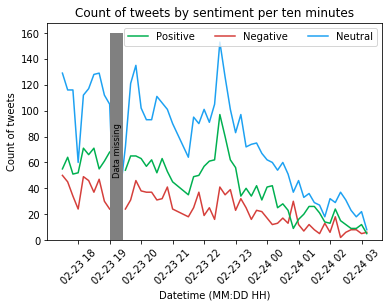

In [7]:
from datetime import datetime

barX = [datetime(2020, 2, 23, 19, 0)]
barY = [160]

width = (datetime(2020, 2, 23, 19, 30) - datetime(2020, 2, 23, 19, 0)).seconds/100000

# Track count of different sentiments

plt.plot(x, pos, label='Positive', color='#00B050', zorder=3)
plt.plot(x, neg, label='Negative', color='#D53F3B', zorder=2)
plt.plot(x, neu, label='Neutral', color = twitter_blue, zorder=1)

# Make it clear that data is missing from 19:10 - 19:30
plt.bar(barX,barY, width= width, align='edge', color ='gray', zorder=4)
plt.text(x=datetime(2020,2,23,19,6), y=50, s='Data missing', fontsize='small', rotation=90, zorder=5)

# Add labels and legend

plt.xlabel(x_label)
plt.ylabel('Count of tweets')
plt.title('Count of tweets by sentiment per ten minutes')
plt.legend(loc='upper right', ncol=3)
plt.xticks(rotation=45)

# Save the figure
plt.savefig(pop + '/count_sentiment.png', bbox_inches='tight')

# Display
plt.show()

To highlight the positive tweets and set them apart from the neutral and negative
tweets, the next plot displays the percentage of tweets in each 10-minute timeslot
that are positive.

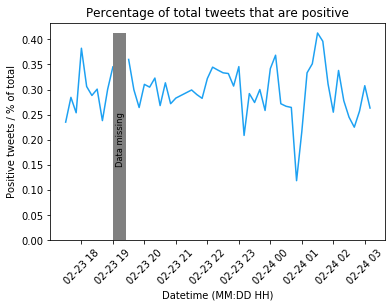

In [8]:
# Track percentage of tweets that are positive
plt.plot(x, y, label='Percentage positive', color = twitter_blue)

# Make it clear that data is missing from 19:10 - 19:30
plt.bar(barX,[max(y)], width= width, align='edge', color ='gray', zorder=4)
plt.text(x=datetime(2020,2,23,19,6), y=0.15, s='Data missing', fontsize='small', rotation=90, zorder=5)

# Label the axes and add title
plt.xlabel(x_label)
plt.ylabel('Positive tweets / % of total')
plt.title('Percentage of total tweets that are positive')
plt.xticks(rotation=45)

# Save the plot
plt.savefig(pop + '/percentage_positive.png', bbox_inches='tight')
plt.show()

For the final time series plot, the average sentiment for each ten-minute
timeslot is calculated and plotted against time.

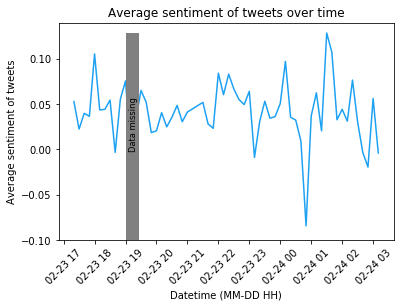

In [9]:
# Plot the average sentiment over time.

df_meansentiment = df_filtered.groupby('datetime_slot')['polarity'].mean()
x = df_meansentiment.index
y = df_meansentiment

plt.plot(x, y, color=twitter_blue)

# Make it clear that data is missing from 19:10 - 19:30
plt.bar(barX,[max(y)+0.1], bottom=-0.1, width= width, align='edge', color ='gray', zorder=4)
plt.text(x=datetime(2020,2,23,19,6), y=0.0, s='Data missing', fontsize='small', rotation=90, zorder=5)

# Add axis labels and title
plt.xlabel('Datetime (MM-DD HH)')
plt.ylabel('Average sentiment of tweets')
plt.title('Average sentiment of tweets over time')
plt.xticks(rotation=45)

# Save the figure
plt.savefig(pop+'/average_sentiment.png', bbox_inches='tight')
plt.show()

 
Finally, a histogram plot is used to display the total count of tweets by
their polarity, across all tweets collected from the beginning 
of the stream up until datetime slot 2020-02-24 08:10:00.
 

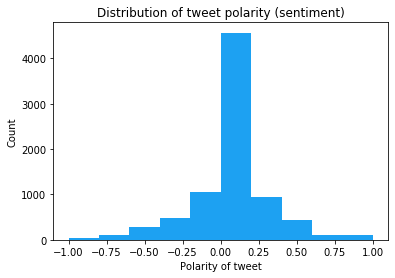

In [10]:
# Plot a histogram of tweet polarity (sentiment)

plt.hist(df_filtered.polarity, bins = 10, color=twitter_blue)
plt.xlabel('Polarity of tweet')
plt.ylabel('Count')
plt.title('Distribution of tweet polarity (sentiment)')
plt.savefig(pop+'/histogram.png', bbox_inches='tight')
plt.show()